**Pre-processing**


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import datetime

#Reading in raw data
df=pd.read_csv('C:/Users/Rory/Downloads/ppd_data.csv',index_col = 'unique_id')
#Keeping copy of raw data
df_old=df
#Changing to datetime format
df['deed_date'] = pd.to_datetime(df['deed_date'])
df['deed_date'].dtype

#Choosing to keep only useful features
df=df[['price_paid','deed_date','postcode','property_type','new_build']]

In [2]:
#Missing values
print(df.isnull().sum())

#Very few missing values, so we will drop them
df.dropna(inplace=True)

price_paid        0
deed_date         0
postcode         91
property_type     0
new_build         0
dtype: int64


C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [3]:
#Simplifying postal code to only be numberic 
df['postcode']=df['postcode'].str.replace(" ","")
df['postcode']=df['postcode'].str.extract("(\d+)")
df['postcode']=df['postcode'].astype('int32')

#Removing postcodes with less than 10 samples
postcode_counts=df['postcode'].value_counts()
to_remove=postcode_counts[postcode_counts<=10].index
# ~ : this operator means to negate
df=df[~df.postcode.isin(to_remove)]

#Shortening price column name
df['price']=df['price_paid']
df_old['price']=df_old['price_paid']

#Shortening date column name
df['date']=df['deed_date']
df_old['date']=df_old['deed_date']

C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rory\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

(733773.0, 737425.0)

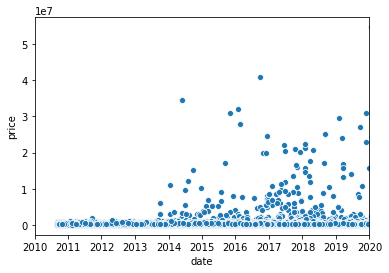

In [4]:
#Scatter plot of price and date over a decade
ax=sns.scatterplot(x="date", y="price", data=df)
ax.set_xlim([datetime.date(2010, 1, 1), datetime.date(2020, 1, 1)])

In [5]:
#Outlier removal - lets get rid of those million pound houses.....

prevmax=df['price'].max()
#Setting up year feature
df['Year']=df['date'].dt.year
#Creating list for outliers to go in
outliers=[]
#3 sigma threshold
threshold=3
#Calculating the median for each year
yr_median=pd.DataFrame(df.groupby(['Year'], as_index=False)['price'].median().set_index('Year'))
#Calculating the standard deviation for each year
yr_std=pd.DataFrame(df.groupby(['Year'], as_index=False).agg({'price':['std']}).set_index('Year'))
#Iterates through each year, using the median and standard deviation for that year to calculate outliers. YEARLY.
for d in df['Year'].unique():                
    for label, row in df.iterrows():
        if row['Year']==d:
            z_score= np.divide(np.subtract(row['price'], (yr_median.values[yr_median.index==d])),(yr_std.values[yr_std.index==d]))
            if np.abs(z_score) > threshold:
                outliers.append(label)
        
#Removing outliers from dataframe
for i in outliers:
    df.drop(i , inplace=True)
newmax=df['price'].max()
#Number of outliers removed
print('Number of outliers removed:')
print(len(outliers))
print('Previous max price: %d  Max price with outliers removed: %.2f' %(prevmax, newmax))

Number of outliers removed:
425
Previous max price: 54600000  Max price with outliers removed: 2935000.00


Text(0.5,1,'Post-outlier removal')

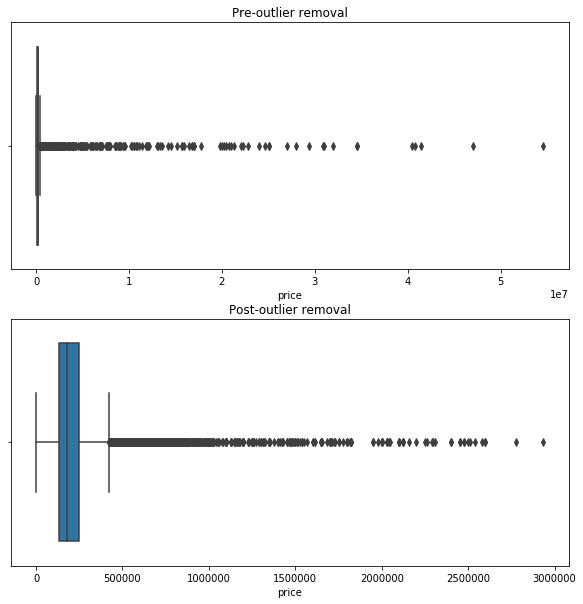

In [6]:
#Outlier removal boxplots
f, axes=plt.subplots(2,1, figsize=(10,10))
sns.boxplot(x="price", data=df_old, ax=axes[0]).set_title('Pre-outlier removal')
sns.boxplot(x="price", data=df, ax=axes[1]).set_title('Post-outlier removal')

[734016.0, 737612.0, 734016.0, 737612.0]

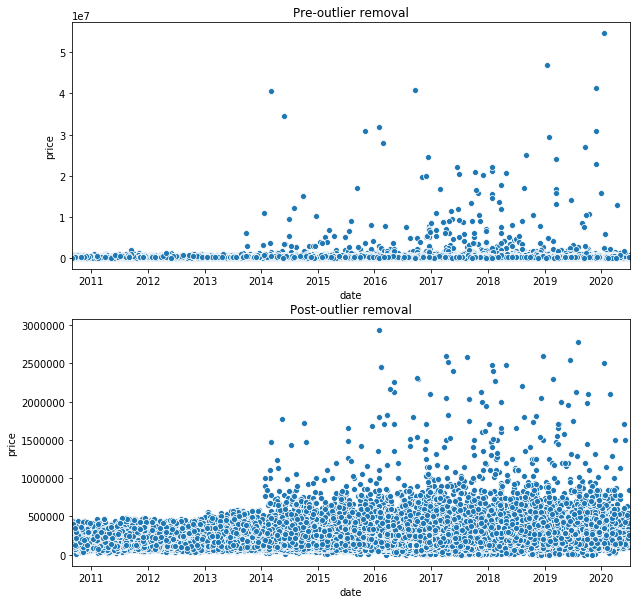

In [7]:
#Outlier removal scatter plots
f, axes=plt.subplots(2,1, figsize=(10,10))
sns.scatterplot(x="date", y="price", data=df_old,ax=axes[0]).set_title('Pre-outlier removal')
sns.scatterplot(x="date", y="price", data=df, ax=axes[1]).set_title('Post-outlier removal')
custom_xlim=([df['date'].min(), df['date'].max()])
plt.setp(axes,xlim=custom_xlim)


**Explatory Data Analysis**

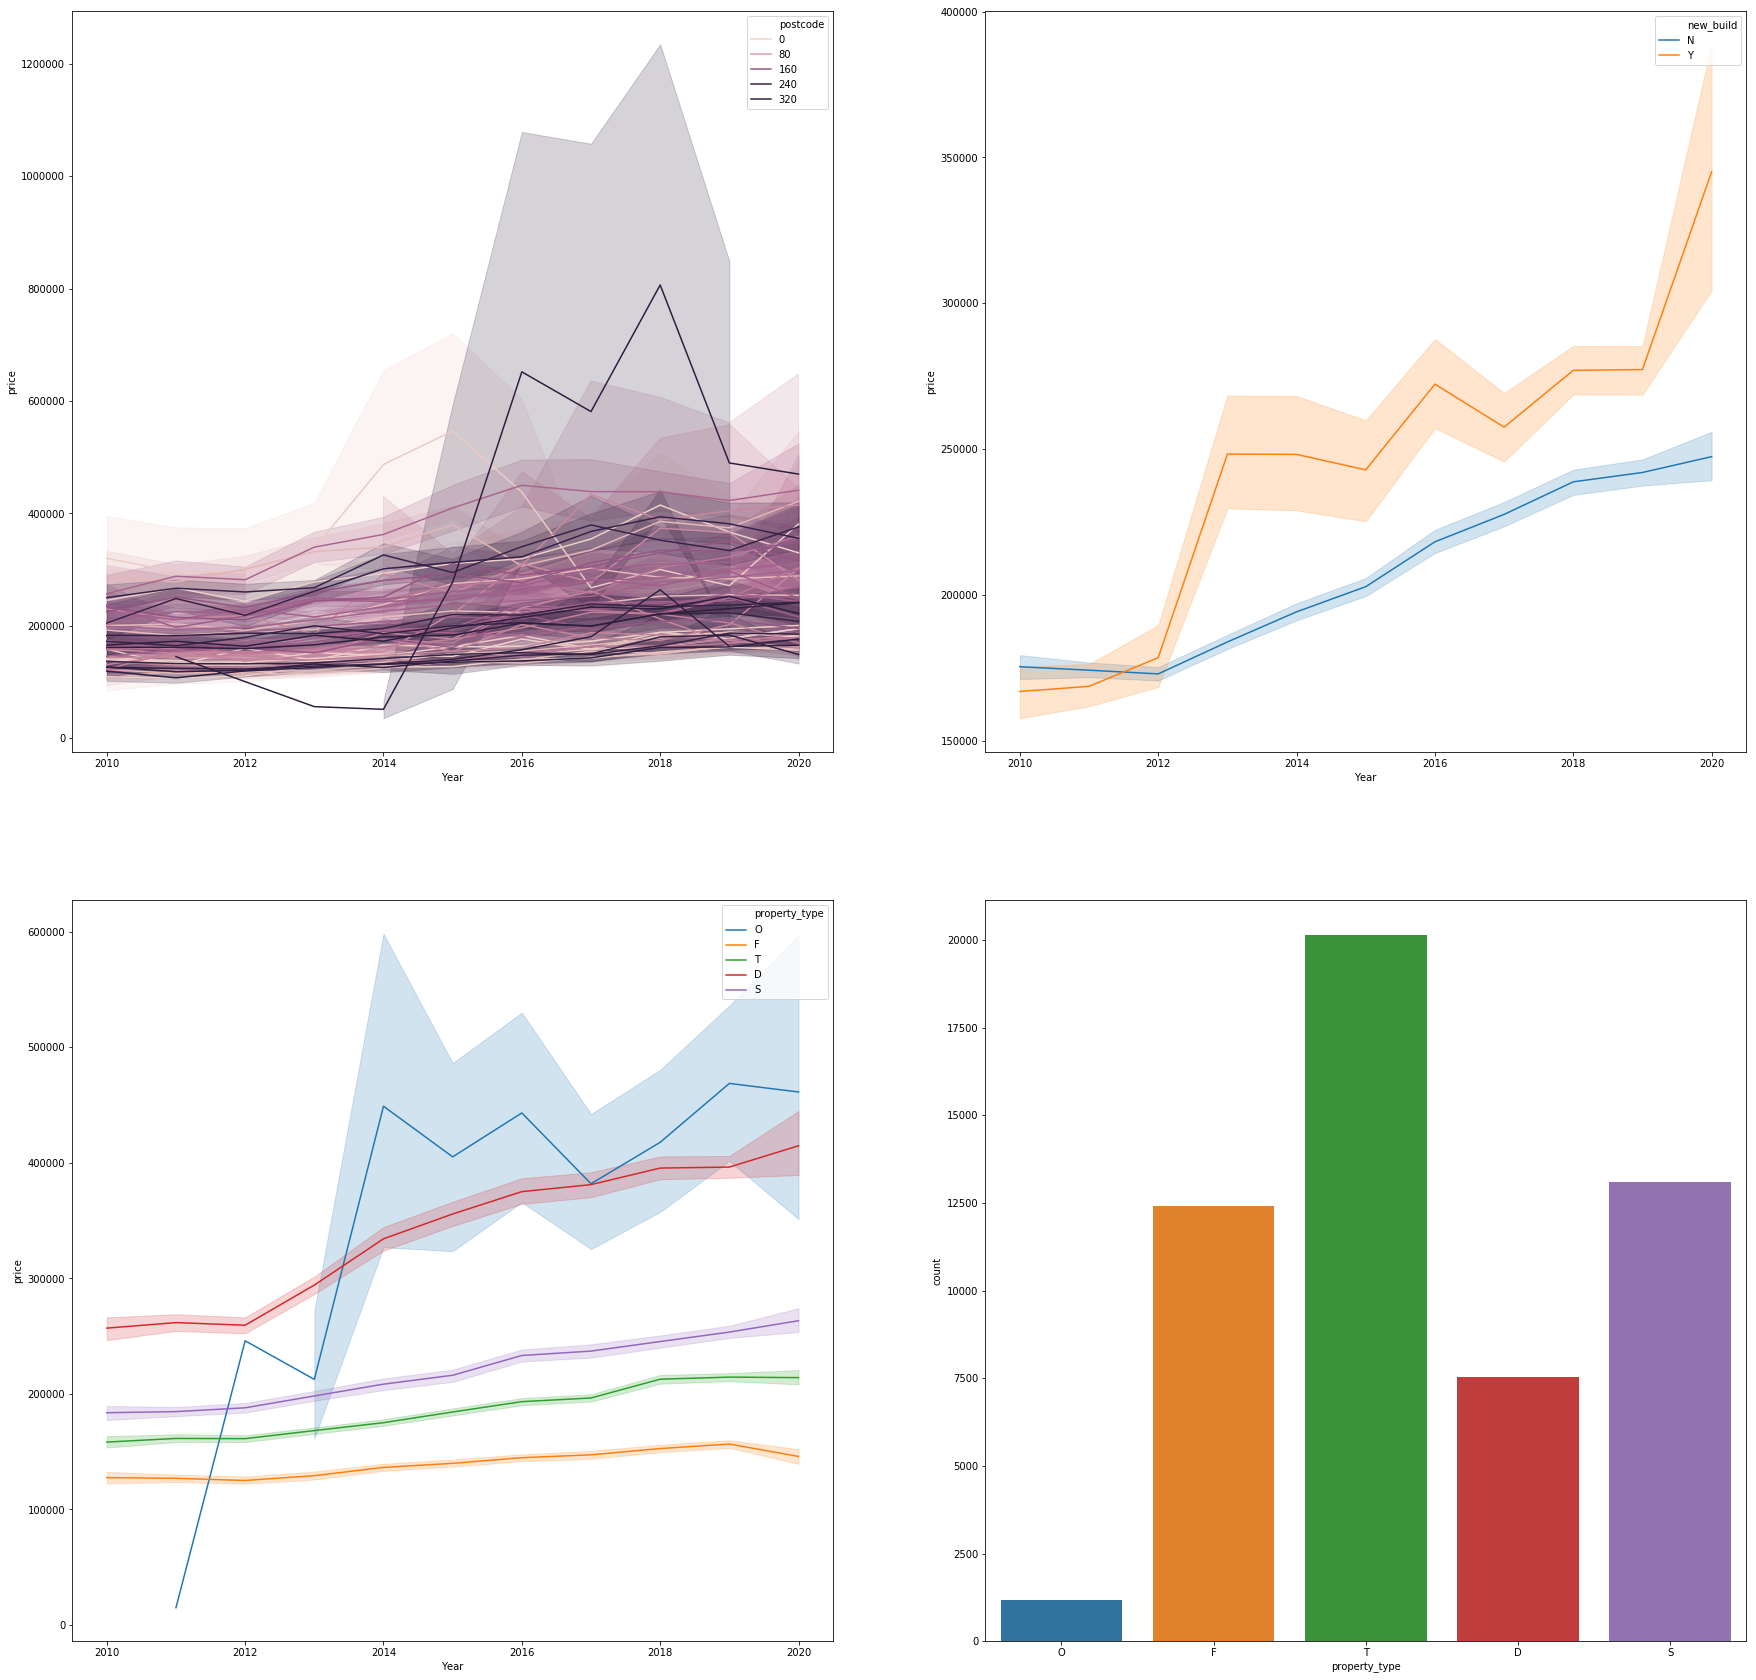

In [8]:
#Subplots of features
f, axes= plt.subplots(2,2, figsize=(30,30))
sns.lineplot(x="Year", y="price", hue="postcode", data=df, ax=axes[0,0])
sns.lineplot(x="Year", y="price", hue="property_type", data=df,ax=axes[1,0])
sns.lineplot(x="Year", y="price", hue="new_build", data=df,ax=axes[0,1])
sns.countplot(x="property_type", data=df,ax=axes[1,1])

The majority of the postcodes show a weak positive correlation with price and date. However there are two postcodes which have periods of strong negative correlation: light lines from 2015 and the dark line from 2018. These two will heavily lower the overall correlation of the feature 'postcode' with price.

New builds show a general positive increase in price with time, however the increase fluctuates heavily over the ten year period. Old builds have a steady increase in price over the ten year period.

All property types apart from other show a weak increase in price over the ten years.

The dataset is primarily made up from terrace house sales, with good sample sizes in flats, detached and semi-detached as well. With roughly 1000 samples in other, this sample size is significantly smaller than the other property types, and I believe it should probably be removed, looking at the price plot, the prices for other are very skewed and hence will hinder the performance of a model.


In [9]:
df['binlabels'], binedges=pd.qcut(df['price'],30,labels=False, retbins=True)
replacer=list(range(0,30))
for i in replacer:
    df['binlabels'].replace(i, binedges[i], inplace=True)
ptype=pd.get_dummies(data=df['property_type'],prefix="ptype")
new=pd.get_dummies(data=df['new_build'],prefix="new")
df=pd.concat([df,ptype,new],axis=1)
df['pricebinned']=df['binlabels']
df.drop(['property_type','new_build','price_paid','deed_date','price','binlabels'],axis=1,inplace=True)

I have chosen to a feature that bins house price, using 30 bins. This is to allow models to predict prices to a 'ballpark' figure. Without binning there could be upto ~ 1,000,000 possible outcomes, now with bins there are only 30. This allows proper statistical evaluation of models.

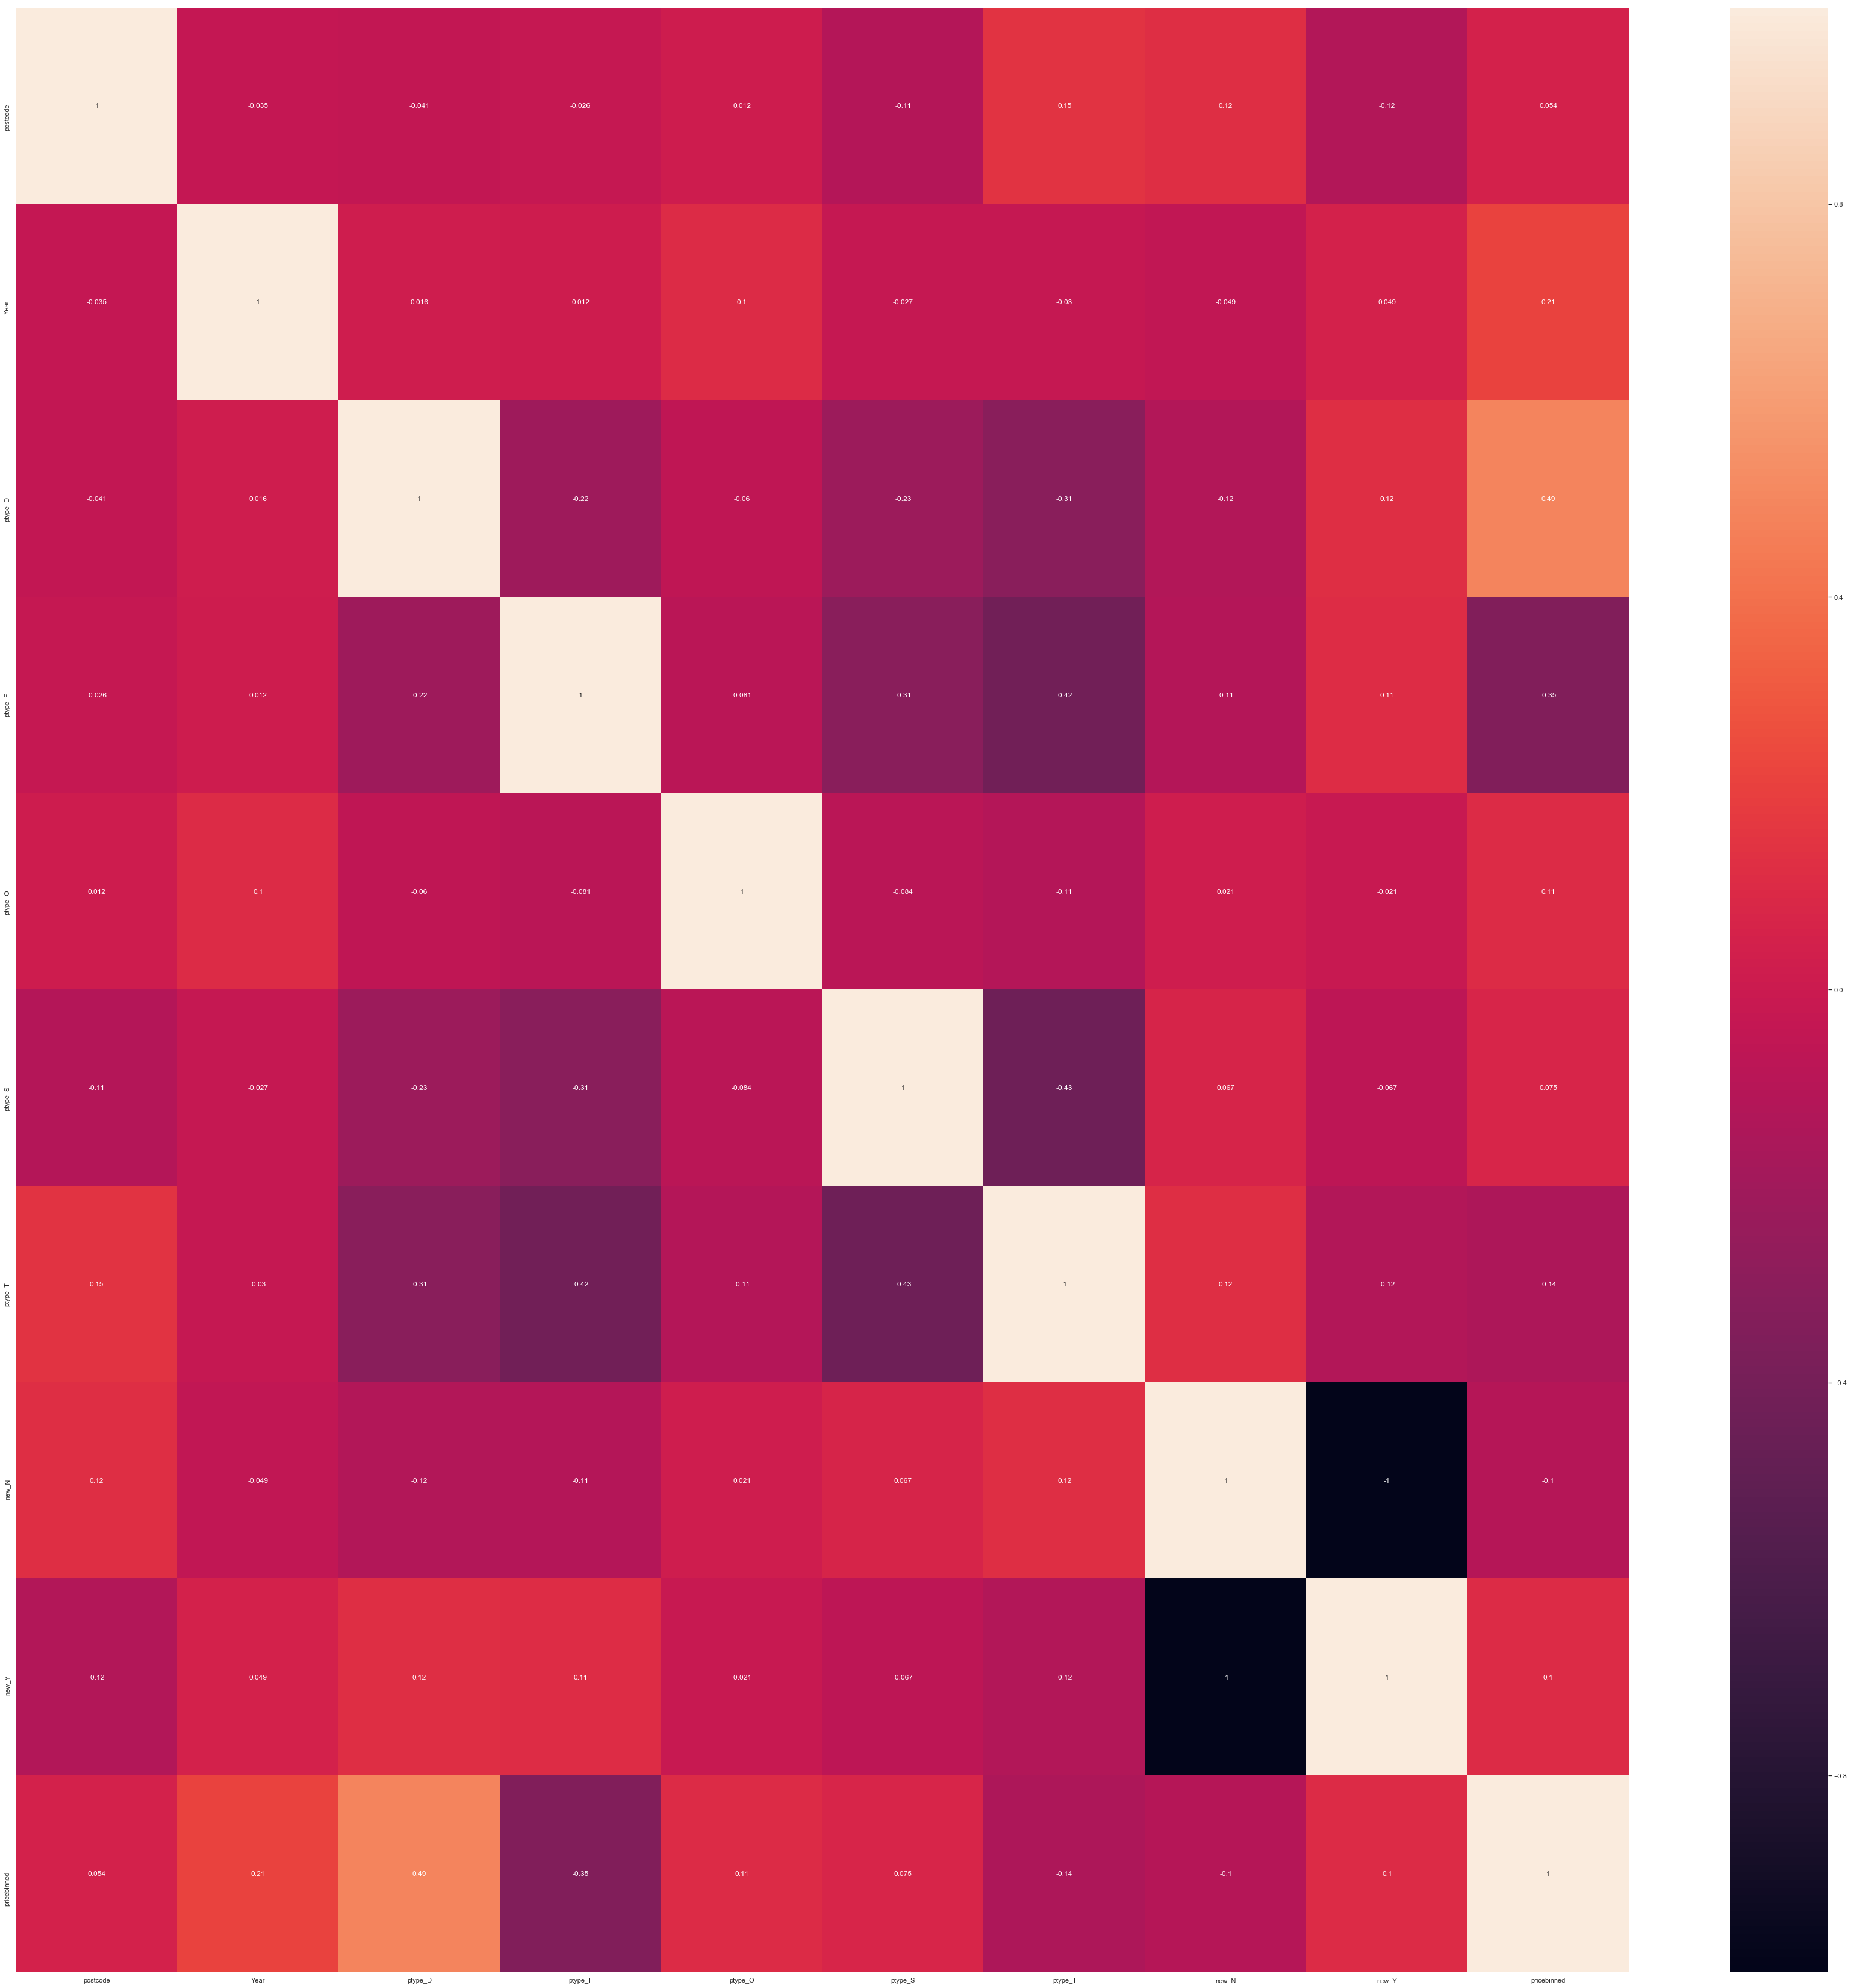

In [10]:
heatmapcorr=df.corr()
sns.set(rc={'figure.figsize':(60,60)})
sns.heatmap(heatmapcorr, annot=True)

As one would imagine, there is positive correlation with year, although only 0.2. This only takes into account year and price, not the property type, hence the low correlation.

The highest positive correlation is with detatched houses and the highest negative with flats.